# Import Library

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Data Preparation

In [3]:
# load dataset from hugging face
dataset = load_dataset("garythung/trashnet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

In [4]:
# training data and transform
train_dataset = dataset['train']

In [5]:
# Prepare data for Tensorflow
image_size = (128, 128)
def preprocess_data(item):
  image = tf.image.resize(item['image'], image_size) / 255.0
  label = item['label']
  return image, label

In [6]:
# Create TensorFlow datasets
tf_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocess_data(item) for item in train_dataset),
    output_signature = (
        tf.TensorSpec(shape=(128,128,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int64)
    )
)

In [8]:
# Split into train, validation, and test sets
train_size = int(0.7 * len(train_dataset))
val_size = int(0.15 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size

train_data = tf_dataset.take(train_size)
remaining = tf_dataset.skip(train_size)
val_data = remaining.take(val_size)
test_data = remaining.skip(val_size)

In [9]:
# Batch and prefetch data
batch_size = 32
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Exploratory Image Analysis

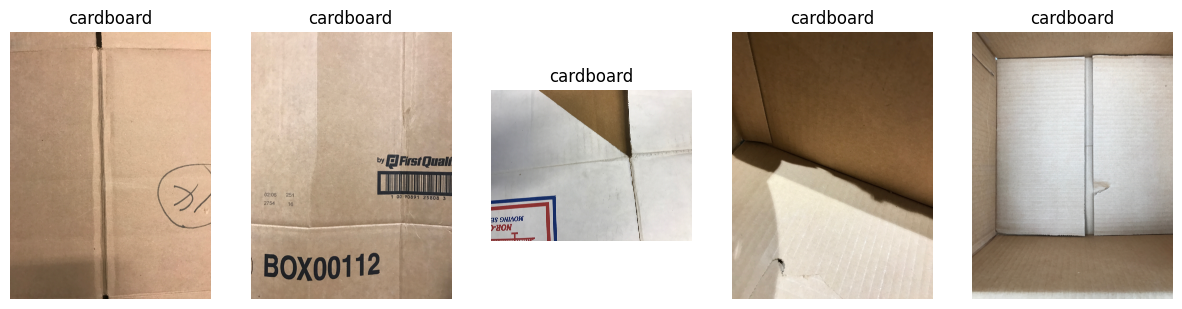

In [ ]:
# Visualize sample images
def show_sample_images(dataset, classes, num_samples=5):

  fig, axes = plt.subplots(1, num_samples, figsize=(15,5))
  for i, item in enumerate(dataset.take(num_samples)):
    image = np.array(item['image'])
    axes[i].imshow(image)
    axes[i].set_title(class_names[item['label']])
    axes[i].axis('off')
  plt.show()

class_names = train_dataset.features['label'].names
show_sample_images(train_dataset, class_names)

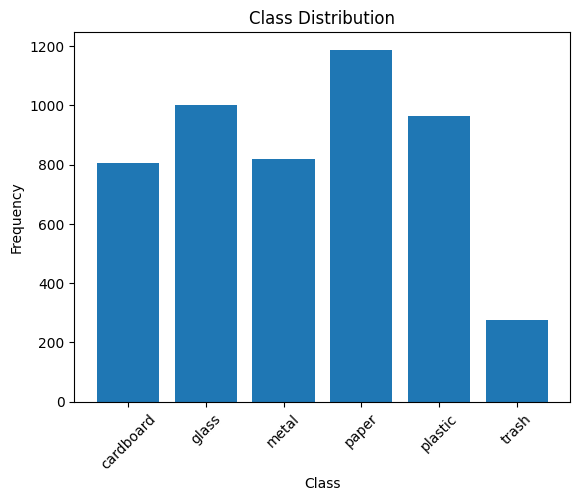

In [ ]:
# check class distribution
from collections import Counter
labels = [item['label'] for item in train_dataset]
label_counts = Counter(labels)

plt.bar(class_names, [label_counts[i] for i in range(len(class_names))])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

* Based on the Class Distribution image, class paper has the most amount of data which is around 1200 data and the lowest is class trash around 300 data.
* For cardboard, metal, glass, and plastic classes, the data distribution is almost evenly distributed between 800 to 1000 data.
* This dataset is imbalanced so that it can affect poor model performance, where the model tends to predict classes with more data.
* Some things that can be done are:
  - Oversampling: increase the data in the minority class.
  - Undersampling: reducing data on the majority class
  - Class weights: give a certain weight to the minority class, namely trash so that the model pays more attention to the class.
  - Data augmentation: increase the number and variety of all classes so that the amount of data for each class can be evenly distributed.

# Model Development

In [13]:
# Define the model
class_names = train_dataset.features['label'].names

input_shape = (128,128,3)
model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(class_names), activation='softmax')
  ])

In [15]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 10
)

Epoch 1/10
    111/Unknown 718s 4s/step - accuracy: 0.3551 - loss: 1.6782

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


111/111 ━━━━━━━━━━━━━━━━━━━━ 1520s 11s/step - accuracy: 0.3554 - loss: 1.6770 - val_accuracy: 0.0185 - val_loss: 1.9060
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1445s 11s/step - accuracy: 0.4952 - loss: 1.2701 - val_accuracy: 0.1979 - val_loss: 1.7458
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1383s 10s/step - accuracy: 0.5314 - loss: 1.2205 - val_accuracy: 0.1821 - val_loss: 2.0963
Epoch 4/10
110/111 ━━━━━━━━━━━━━━━━━━━━ 3s 4s/step - accuracy: 0.5585 - loss: 1.1522 

In [ ]:
model.save('coba.h5')

In [ ]:
# Plot training history
def plot_history(history):
  plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.legend()
  plt.title('Accuracy')

  plt.figure(figsize=(12,4))
  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.legend()
  plt.title('Loss')

  plt.show()

plot_history(history)

# Model Evaluation

In [ ]:
# evaluation on test set
test_loss, test_acc = model.evaluate(test_data)
print(f"Test accuracy: {test_acc}")

In [ ]:
# generate prediction and calassification report
y_preds, y_true = [], []
for images, labels in test_data:
  preds = model.predict(images)
  y_preds.extend(tf.argmax(preds, axis=1))
  y_true.extend(labels.numpy())

print(classification_report(y_true, y_preds, target_names=class_names))